In [1]:
import os
import re
import json
import nltk
import string
import enchant
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

#### Data Inspection

In [2]:
ids_labels = pd.read_csv('task2-tweets.csv')
ids_labels.head()

covid_data = []

for i in tqdm(range(len(ids_labels))):
    id = ids_labels['Id'][i]
    fname = str(id) + '.json'
    file = open('task2-tweet-objects/'+fname)
    instance = json.load(file)
    covid_data.append(instance)
    
covid_data = pd.DataFrame(covid_data)
covid_data.head()

100%|██████████| 161943/161943 [02:01<00:00, 1330.05it/s]


,id,entities,created_at,source,text,withheld
0,1272262651100434433,"{'urls': [{'start': 244, 'end': 267, 'url': 'h...",2020-06-14T20:20:28.000Z,Twitter for iPhone,"According to the New York Times, Warner Bros. ...",NaN
1,1287153210990395392,"{'urls': [{'start': 148, 'end': 171, 'url': 'h...",2020-07-25T22:30:14.000Z,Sprout Social,Hurricane Hanna has made landfall in Texas.\n\...,NaN
2,1287191952115605505,"{'mentions': [{'start': 0, 'end': 13, 'usernam...",2020-07-26T01:04:10.000Z,Twitter for iPhone,@TexasTribune Guess what the cause of death is...,NaN
3,1266555444283179008,"{'annotations': [{'start': 24, 'end': 28, 'pro...",2020-05-30T02:22:04.000Z,SocialFlow,Monkeys on the loose in India with stolen coro...,NaN
4,1258212704961155073,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",2020-05-07T01:50:59.000Z,Twitter Web App,@BelAkinyii Let's not play blind that the work...,NaN


In [25]:
ids_labels = pd.read_csv('task2-tweets.csv')
covid_label = pd.DataFrame(ids_labels['Label'])
covid_label.columns = ['label']
covid_data = pd.concat([covid_data, covid_label], axis=1)

#### Data Cleaning

In [4]:
# clean @at, namely clean username
def clean_at(data):
    return re.sub('@[^\s]+', ' ', data)

# clean URLs
def clean_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

# clean &amp
def clean_amp(data):
    return  ' '.join([word for word in data.split() if word != 'amp'])


# clean numbers
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)

def clean_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
    

# clean non-english words
def clean_non_english_word(data):
    d = enchant.Dict('en_US') # english dictionary
    return ' '.join([word for word in data.split() if d.check(word)])

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
def clean_stopwords(data):
    return ' '.join([word for word in data.split() if word not in stopwords])

def clean_punctuations(data):
    punctuations_list = string.punctuation
    translator = str.maketrans('', '', punctuations_list)
    return data.translate(translator)

# stemming
def stemming(data):
    st = PorterStemmer()
    return ' '.join([st.stem(word) for word in data.split()])

# Lemmatization
def lemmatization(data):
    wnl = WordNetLemmatizer()
    return ' '.join([wnl.lemmatize(word) for word in data.split()])

In [5]:
covid_data['text'] = covid_data['text'].str.lower()
covid_data['text'] = covid_data['text'].apply(lambda x:clean_at(x))
covid_data['text'] = covid_data['text'].apply(lambda x:clean_URLs(x))
covid_data['text'] = covid_data['text'].apply(lambda x:clean_emojis(x))
covid_data['text'] = covid_data['text'].str.replace("[^a-zA-Z#]", " ")
covid_data['text'] = covid_data['text'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
covid_data['text'] = covid_data['text'].str.replace('@[A-Za-z0-9]+', '') 
covid_data['text'] = covid_data['text'].str.replace('\n', ' ') 
covid_data['text'] = covid_data['text'].apply(lambda x: clean_non_english_word(x))
covid_data['text'] = covid_data['text'].apply(lambda x: clean_stopwords(x))
covid_data['text'] = covid_data['text'].apply(lambda x: clean_punctuations(x))
covid_data['text'] = covid_data['text'].apply(lambda x: lemmatization(x))
covid_data['text'] = covid_data['text'].apply(lambda x: clean_amp(x))
covid_data['text'].head()

/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_1356/3632798638.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace("[^a-zA-Z#]", " ")
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_1356/3632798638.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '')
/var/folders/xl/l07cxwy94pgcqqp6n3npqbt80000gn/T/ipykernel_1356/3632798638.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['text'] = covid_data['text'].str.replace('@[A-Za-z0-9]+', '')


0    according new time bros wanted delay month ago...
1    hurricane made landfall storm hitting section ...
2     guess cause death hurricane good way ramp number
3                     monkey loose stolen blood sample
4                let play blind work fighting religion
Name: text, dtype: object

In [116]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
from tqdm import tqdm
sentiments = []
for i in tqdm(range(len(covid_data))):
    tweet = covid_data['text'][i]
    sentiment = classifier(tweet)[0]['label']
    sentiments.append(sentiment)

sentiments = pd.DataFrame(sentiments)
sentiments.columns = ['sentiment']

sentiments.to_csv('crawl-sentiment.csv', index=False)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
100%|██████████| 161943/161943 [2:34:23<00:00, 17.48it/s]  


In [117]:
sentiments = pd.read_csv('crawl-sentiment.csv')
sentiments

,sentiment
0,NEGATIVE
1,NEGATIVE
2,NEGATIVE
3,NEGATIVE
4,NEGATIVE
...,...
161938,NEGATIVE
161939,NEGATIVE
161940,NEGATIVE
161941,NEGATIVE


In [20]:
covid_ids = open('project-data/covid.data.txt').readlines()
covid_ids

tmp = []
for line in covid_ids:
    tmp.append(line.rstrip('\n'))

firsts_lasts = []
for line in tmp:
    instance = line.split(',')
    if len(instance) > 1:
        first = instance[0]
        last = instance[-1]
        firsts_lasts.append({'first':first, 'last':last})

firsts_lasts = pd.DataFrame(firsts_lasts)
firsts_lasts.head()

dict_ids_labels = {}
for j in range(len(ids_labels)):
    search_id = ids_labels['Id'][j]
    search_label = ids_labels['Label'][j]
    dict_ids_labels[search_id] = search_label

first_last_labels = []
from tqdm import tqdm
for i in tqdm(range(len(firsts_lasts))):
    first_id = int(firsts_lasts['first'][i])
    last_id = int(firsts_lasts['last'][i])
    first_label = dict_ids_labels.get(first_id,-1)
    last_label = dict_ids_labels.get(last_id,-1)
    first_last_labels.append({'first label': first_label, 'last label': last_label})


firsts_lasts = pd.read_csv('change.csv')
firsts_lasts

100%|██████████| 13804/13804 [00:00<00:00, 47700.52it/s]


,first id,last id,first label,last label
0,1287153210990395392,1287191952115605505,0,0
1,1257715199655755779,1258230330210779143,-1,0
2,1274338812173393920,1274423411645779973,0,0
3,1249421782630772746,1249422965722230785,0,0
4,1274091468890632192,1274129512746438657,0,0
...,...,...,...,...
13799,1249502859185590272,1249755942582960129,0,0
13800,1284050414619459586,1284118672009842688,0,1
13801,1274505289614725122,1274548079648223243,1,0
13802,1267884642637676545,1267892868603092994,0,0


In [21]:
firsts_lasts = pd.read_csv('change.csv')
firsts_lasts

,first id,last id,first label,last label
0,1287153210990395392,1287191952115605505,0,0
1,1257715199655755779,1258230330210779143,-1,0
2,1274338812173393920,1274423411645779973,0,0
3,1249421782630772746,1249422965722230785,0,0
4,1274091468890632192,1274129512746438657,0,0
...,...,...,...,...
13799,1249502859185590272,1249755942582960129,0,0
13800,1284050414619459586,1284118672009842688,0,1
13801,1274505289614725122,1274548079648223243,1,0
13802,1267884642637676545,1267892868603092994,0,0


#### Rumour Label Evolution Analysis

In [23]:
change_cnt = 0
total_cnt = 0
for i in tqdm(range(len(firsts_lasts))):
    first_label = firsts_lasts['first label'][i]
    last_label = firsts_lasts['last label'][i]
    if first_label != -1 and last_label != -1:
        total_cnt += 1
        if first_label != last_label:
            change_cnt += 1

print(round(change_cnt/total_cnt, 4)*100)

100%|██████████| 13804/13804 [00:00<00:00, 49594.60it/s]

17.2


In [118]:
covid_data = pd.concat([covid_data, sentiments], axis=1)

In [119]:
rumours = covid_data[covid_data['label']==1]
rumours = rumours.reset_index(drop=True)
nonrumours = covid_data[covid_data['label']==0]
nonrumours = nonrumours.reset_index(drop=True)

#### Rumour Topic Analysis

In [28]:
def visualize_freq(set, factor, factor_type, top_cnt, label_type, output_fname):
    all_vals = []
    for i in range(len(set)):
        if factor == 'text' or factor == 'user_description':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)

        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            if created_date not in all_vals:
                all_vals.append(created_date)
            

    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency', ascending=False)
    
    # top xxx frequent vals
    frequent_vals = vals_freqs['frequency'][:top_cnt].index

    # plot
    title = "{} Frequency in {} Tweets".format(factor_type, label_type)
    plt.figure(figsize=(12, 18))
    plt.bar(np.arange(top_cnt), vals_freqs['frequency'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
                edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(top_cnt), frequent_vals, fontname="Times New Roman", rotation=90, size=24);
    plt.xlabel("{} most frequent {}".format(str(top_cnt), factor_type), size=28, labelpad=16, fontname="Times New Roman");
    plt.ylabel("Frequency", size=28, labelpad=16, fontname="Times New Roman");
    plt.title(title, size=34, fontname="Times New Roman");
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return frequent_vals

In [29]:
def visualize_freq_percentage(set, factor, factor_type, top_cnt, label_type, output_fname):
    all_vals = []
    for i in tqdm(range(len(set))):
        if factor == 'text' or factor == 'user_description':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)

        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            if created_date not in all_vals:
                all_vals.append(created_date)
            

    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())
    freqs = [round(freq/len(all_vals),4)*100 for freq in freqs]

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency percentage']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency percentage', ascending=False)
    # top xxx frequent vals
    frequent_vals = vals_freqs['frequency percentage'][:top_cnt].index
    print(frequent_vals)

    # plot
    title = "{} Frequency Percentage in {} Tweets".format(factor_type, label_type)
    plt.figure(figsize=(10,12))
    plt.bar(np.arange(top_cnt), vals_freqs['frequency percentage'][:top_cnt], width=0.8, color = sns.color_palette("bwr"), alpha=0.5, 
                edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(top_cnt), frequent_vals, rotation=90, size=14, fontname="Times New Roman");
    plt.xlabel("{} most frequent {}".format(str(top_cnt), factor_type), size=14, labelpad=6, fontname="Times New Roman");
    plt.ylabel("Frequency %", size=14, labelpad=6, fontname="Times New Roman");
    plt.title(title, size=18, fontname="Times New Roman")
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return vals_freqs[:top_cnt]

In [30]:
def visualize_wordcloud(wc_str, label_type, output_fname):
    mask = np.array(Image.open('images/twitter-icon.png'))
    wc = WordCloud(background_color='white', colormap='Set1', mask=mask).generate(wc_str)
    title = '{} Tweets WordCloud'.format(label_type)
    plt.figure(figsize=(6,6), facecolor="w")
    plt.title(title, size=18, fontname="Times New Roman")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('images/'+output_fname, dpi=300)
    plt.show()

rumours_str = pd.Series(rumours['text']).str.cat(sep=' ')
nonrumours_str = pd.Series(nonrumours['text']).str.cat(sep=' ')

In [31]:
def visualize_distribution(set, factor, factor_type, top_cnt, set_type, output_fname):
    all_vals = []
    for i in range(len(set)):
        if factor == 'text':
            values = set[factor][i].split()
            # word
            if values != []:
                for val in values:
                    all_vals.append(val)
        
        if factor == 'hashtags':
            values = set[factor][i]
            if str(values) != 'nan':
                values = eval(values)
                for val in values:
                    all_vals.append(val)
        
        if factor == 'user_location':
            location = set[factor][i]
            if str(location) != 'nan':
                all_vals.append(location)
        
        if factor == 'user_verified' or factor == 'user_name' or factor == 'sentiment' or factor == 'source':
            verify = set[factor][i]
            all_vals.append(verify)

        if factor == 'user_created':
            created_date = set[factor][i]
            created_date = datetime.strptime(created_date, "%Y-%m-%d %H:%M:%S")
            created_date = created_date.strftime('%Y')
            all_vals.append(created_date)
    
    counter = Counter(all_vals)
    vals = list(counter.keys())
    freqs = list(counter.values())

    vals_freqs = pd.DataFrame([freqs]).T
    vals_freqs.columns = ['frequency']
    vals_freqs.index = vals
    vals_freqs = vals_freqs.sort_values('frequency', ascending=False)
    top_freqs = vals_freqs[:top_cnt]
    # top xxx frequent vals
    frequent_vals = top_freqs['frequency'].index

    # plot
    cmap = plt.get_cmap('RdPu')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    plt.figure(figsize=(6, 6))
    plt.pie(top_freqs['frequency'], labels = list(top_freqs.index), autopct='%1.1f%%', colors=colors)
    title = "Sentiment Distribution in {} Tweets".format(set_type)
    plt.title(title, size=18, fontname="Times New Roman")
    plt.savefig('images/'+output_fname, dpi=300, facecolor='w')
    plt.show()
    return top_freqs

Index(['trump', 'people', 'hoax', 'u', 'death', 'lie', 'like', 'president',
       'flu', 'pandemic', 'china', 'get', 'one', 'news', 'know', 'said',
       'would', 'time', 'say', 'go'],
      dtype='object')


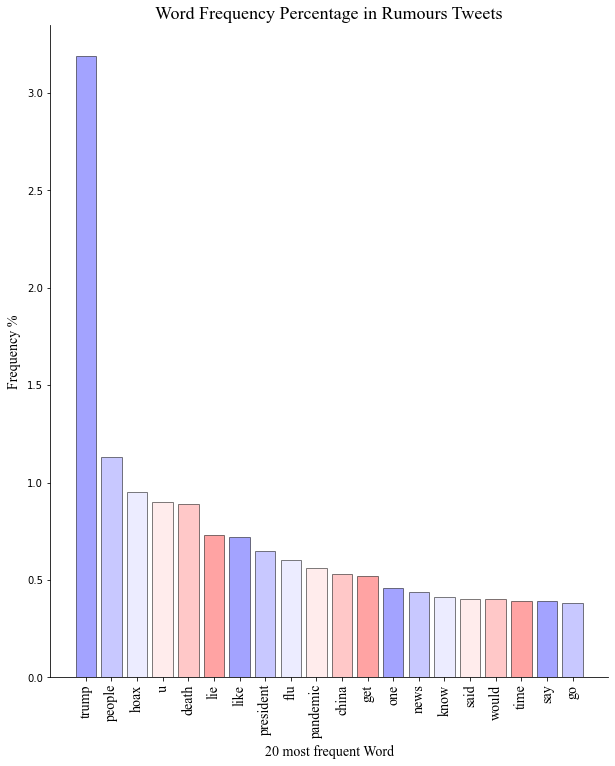

,frequency percentage
trump,3.19
people,1.13
hoax,0.95
u,0.90
death,0.89
lie,0.73
like,0.72
president,0.65
flu,0.60
pandemic,0.56


In [26]:
tmp_rumour = visualize_freq_percentage(rumours, 'text', 'Word', 20, 'Rumours', 'word-freq-per-rumours.png')
tmp_rumour

In [27]:
rumour_topic = ['trump', 'people', 'hoax', 'death', 'lie', 'president', 'flu', 'pandemic', 'china']
rumour_topics_freqs = [3.19, 1.13, 0.95, 0.89, 0.73, 0.65, 0.6, 0.56, 0.53]
rumour_topics = pd.DataFrame(rumour_topics_freqs)
rumour_topics.columns = ['frequency']
rumour_topics.index = rumour_topic
rumour_topics

,frequency
trump,3.19
people,1.13
hoax,0.95
death,0.89
lie,0.73
president,0.65
flu,0.60
pandemic,0.56
china,0.53


100%|██████████| 135818/135818 [13:03<00:00, 173.24it/s]


Index(['people', 'trump', 'death', 'u', 'case', 'get', 'virus', 'one',
       'pandemic', 'like', 'state', 'day', 'would', 'country', 'new', 'need',
       'know', 'test', 'time', 'mask'],
      dtype='object')


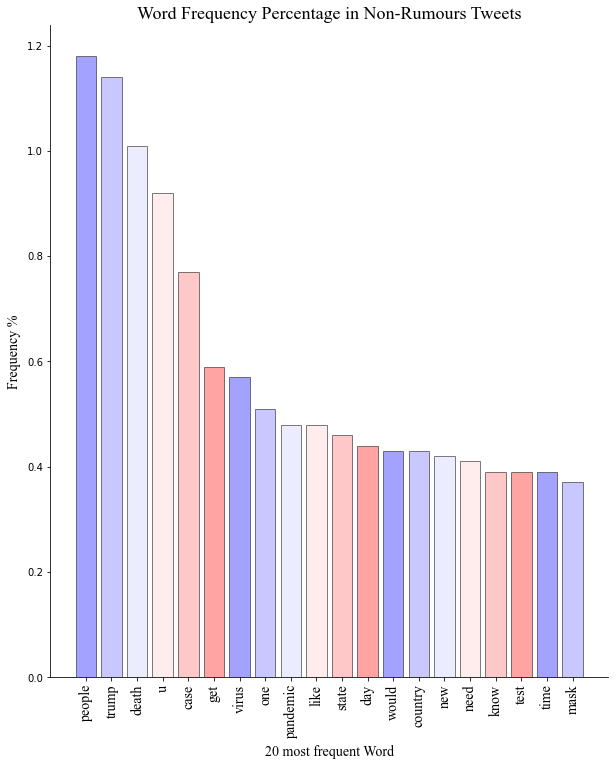

,frequency percentage
people,1.18
trump,1.14
death,1.01
u,0.92
case,0.77
get,0.59
virus,0.57
one,0.51
pandemic,0.48
like,0.48


In [35]:
tmp_nonrumour = visualize_freq_percentage(nonrumours, 'text', 'Word', 20, 'Non-Rumours', 'word-freq-per-rumours.png')
tmp_nonrumour

In [36]:
nonrumour_topic = ['people', 'trump', 'death', 'case', 'virus', 'pandemic', 'state', 'country', 'new']
nonrumour_topics_freqs = [1.18, 1.14, 1.01, 0.77, 0.57, 0.48, 0.46, 0.43, 0.42]
nonrumour_topics = pd.DataFrame(nonrumour_topics_freqs)
nonrumour_topics.columns = ['frequency']
nonrumour_topics.index = nonrumour_topic
nonrumour_topics

,frequency
people,1.18
trump,1.14
death,1.01
case,0.77
virus,0.57
pandemic,0.48
state,0.46
country,0.43
new,0.42


#### Rumour Trend Analysis

In [32]:
dates = []
for i in tqdm(range(len(rumours))):
    date = rumours['created_at'][i][:10]
    date = datetime.strptime(date, "%Y-%m-%d")
    date = date.strftime('%Y-%m-%d')
    if date not in dates:
        dates.append(date)

dates = sorted(dates)

100%|██████████| 26125/26125 [00:01<00:00, 25050.22it/s]


In [33]:
dates = sorted(dates)
periods = []
for i in range(6):
    period = dates[30*i:30*(i+1)]
    if i == 5:
        period = dates[150:]
    periods.append(period)
periods

[['2020-01-27',
  '2020-01-28',
  '2020-01-29',
  '2020-01-30',
  '2020-01-31',
  '2020-02-01',
  '2020-02-02',
  '2020-02-04',
  '2020-02-07',
  '2020-02-11',
  '2020-02-12',
  '2020-02-13',
  '2020-02-14',
  '2020-02-15',
  '2020-02-16',
  '2020-02-17',
  '2020-02-18',
  '2020-02-19',
  '2020-02-20',
  '2020-02-21',
  '2020-02-22',
  '2020-02-23',
  '2020-02-24',
  '2020-02-25',
  '2020-02-26',
  '2020-02-27',
  '2020-02-28',
  '2020-02-29',
  '2020-03-01',
  '2020-03-02'],
 ['2020-03-03',
  '2020-03-04',
  '2020-03-05',
  '2020-03-06',
  '2020-03-07',
  '2020-03-08',
  '2020-03-09',
  '2020-03-10',
  '2020-03-11',
  '2020-03-12',
  '2020-03-13',
  '2020-03-14',
  '2020-03-15',
  '2020-03-16',
  '2020-03-17',
  '2020-03-18',
  '2020-03-19',
  '2020-03-20',
  '2020-03-21',
  '2020-03-22',
  '2020-03-23',
  '2020-03-24',
  '2020-03-25',
  '2020-03-26',
  '2020-03-27',
  '2020-03-28',
  '2020-03-29',
  '2020-03-30',
  '2020-03-31',
  '2020-04-01'],
 ['2020-04-02',
  '2020-04-03',
  '202

In [34]:
for i in range(len(periods)):
    start_time = periods[i][0]
    end_time = periods[i][-1]
    mask = (covid_data['created_at'] > start_time) & (covid_data['created_at'] <= end_time)
    if i == 0:
        # 这里暂时hard code 上去
        period_1 = covid_data.loc[mask]
    if i == 1:
        period_2 = covid_data.loc[mask]
    if i == 2:
        period_3 = covid_data.loc[mask]
    if i == 3:
        period_4 = covid_data.loc[mask]
    if i == 4:
        period_5 = covid_data.loc[mask]
    if i == 5:
        period_6 = covid_data.loc[mask]
    

period_1 = period_1.reset_index(drop=True)
period_2 = period_2.reset_index(drop=True)
period_3 = period_3.reset_index(drop=True)
period_4 = period_4.reset_index(drop=True)
period_5 = period_5.reset_index(drop=True)
period_6 = period_6.reset_index(drop=True)

In [38]:
def period_word_cnt(set):
    cnt = 0
    for i in range(len(set)):
        tweet = set['text'][i].split()
        if tweet != []:
            for word in tweet:
                cnt += 1
    return cnt

cnt_1 = period_word_cnt(period_1)
cnt_2 = period_word_cnt(period_2)      
cnt_3 = period_word_cnt(period_3)      
cnt_4 = period_word_cnt(period_4)         
cnt_5 = period_word_cnt(period_5)      
cnt_6 = period_word_cnt(period_6)        

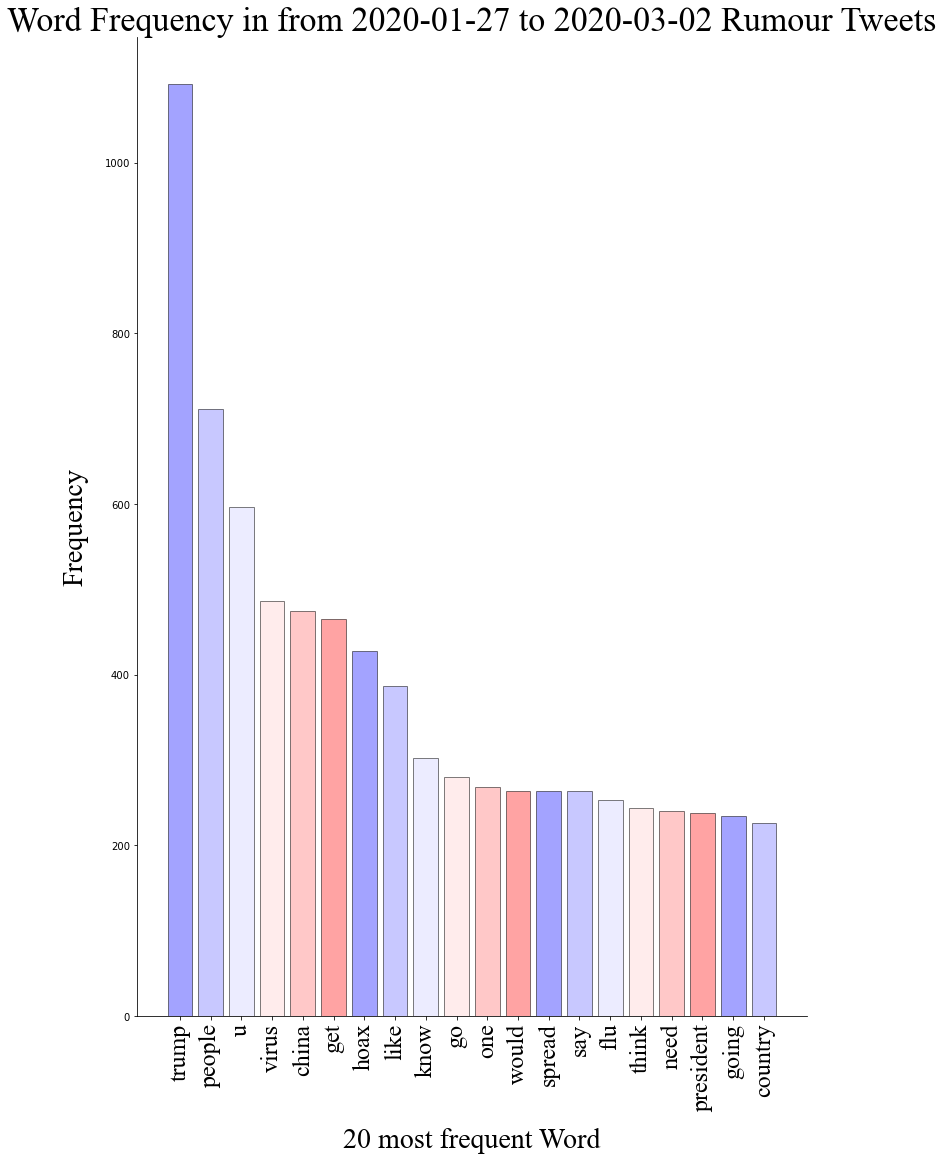

In [74]:
period_1_top_20_words = visualize_freq(period_1, 'text', 'Word', 20, 'from 2020-01-27 to 2020-03-02 Rumour', 'word-freq-rumour-period1.png')

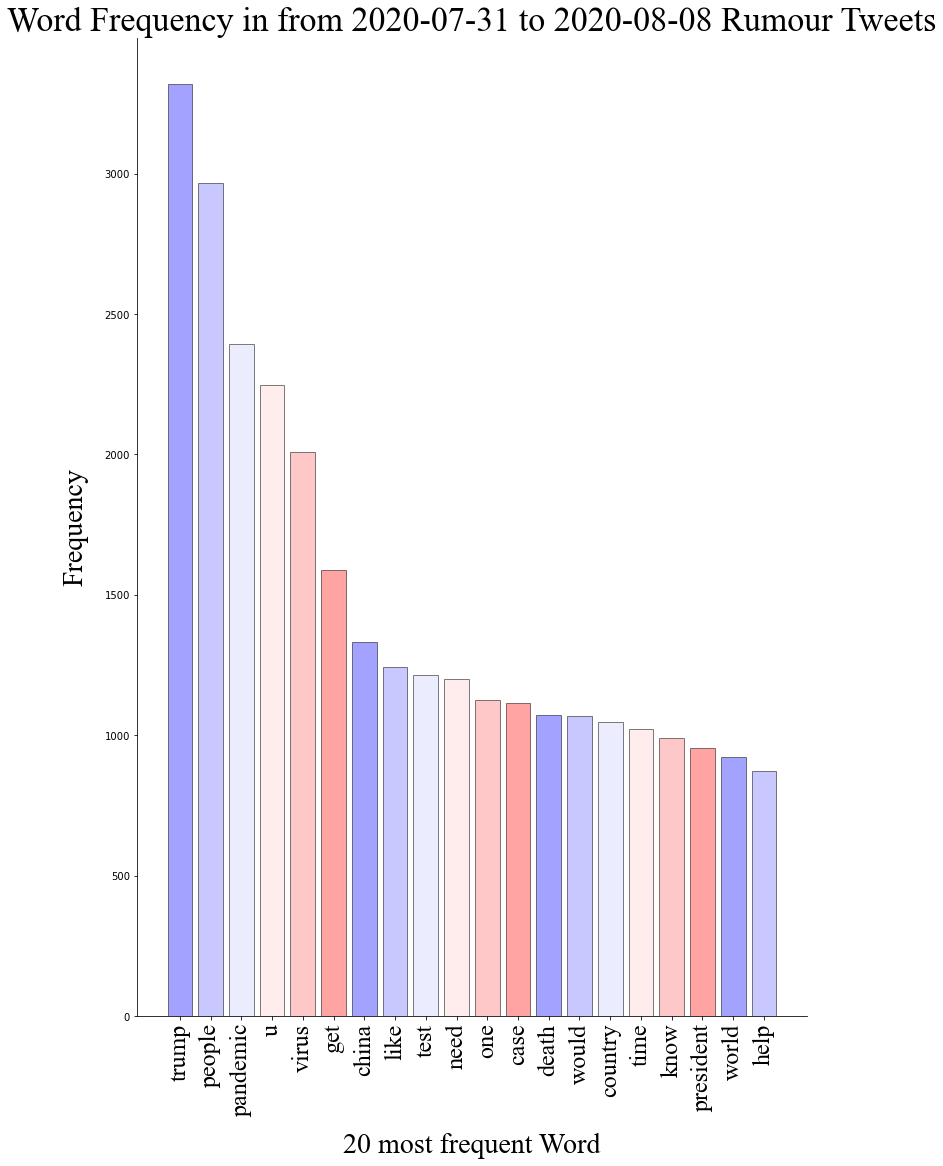

In [75]:
period_2_top_20_words = visualize_freq(period_2, 'text', 'Word', 20, 'from 2020-07-31 to 2020-08-08 Rumour', 'word-freq-rumour-period2.png')

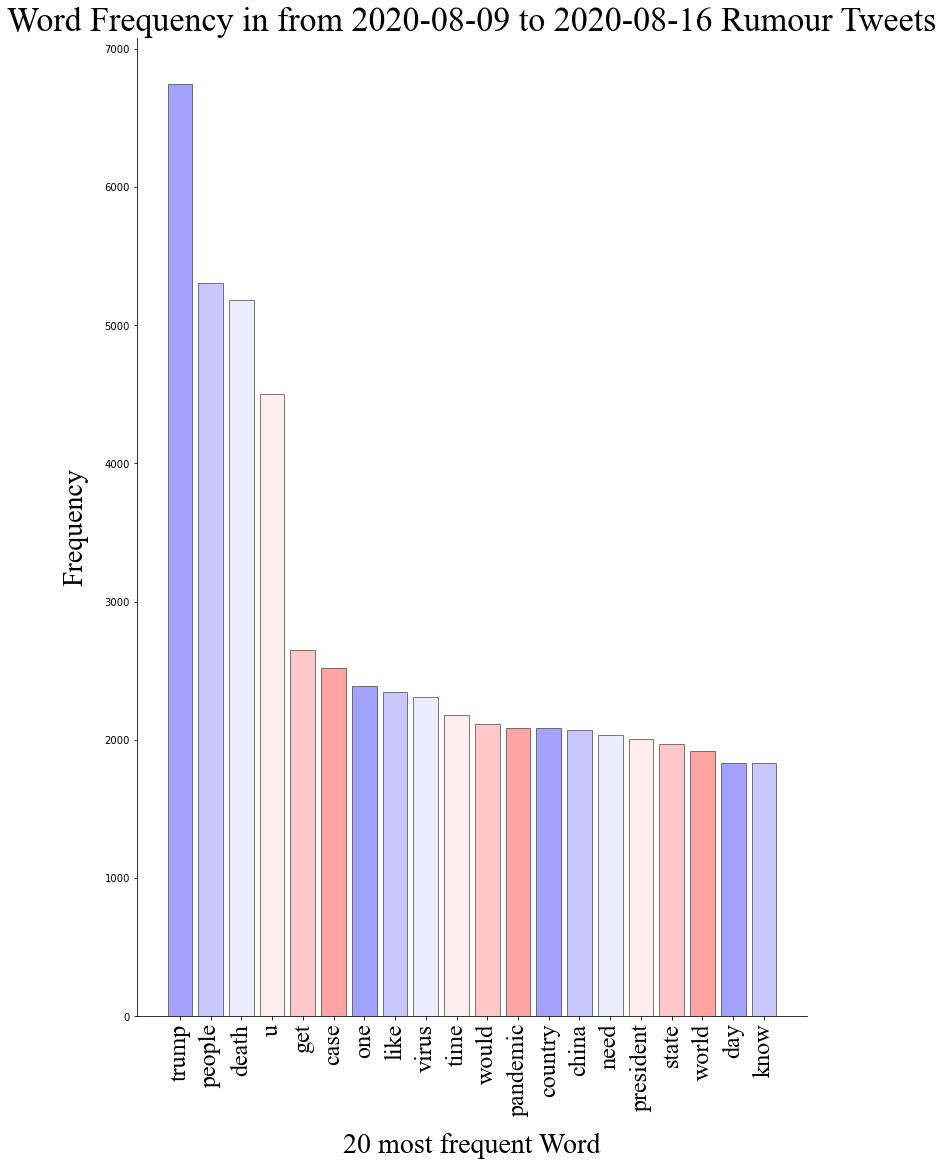

In [76]:
period_3_top_20_words = visualize_freq(period_3, 'text', 'Word', 20, 'from 2020-08-09 to 2020-08-16 Rumour', 'word-freq-rumour-period3.png')

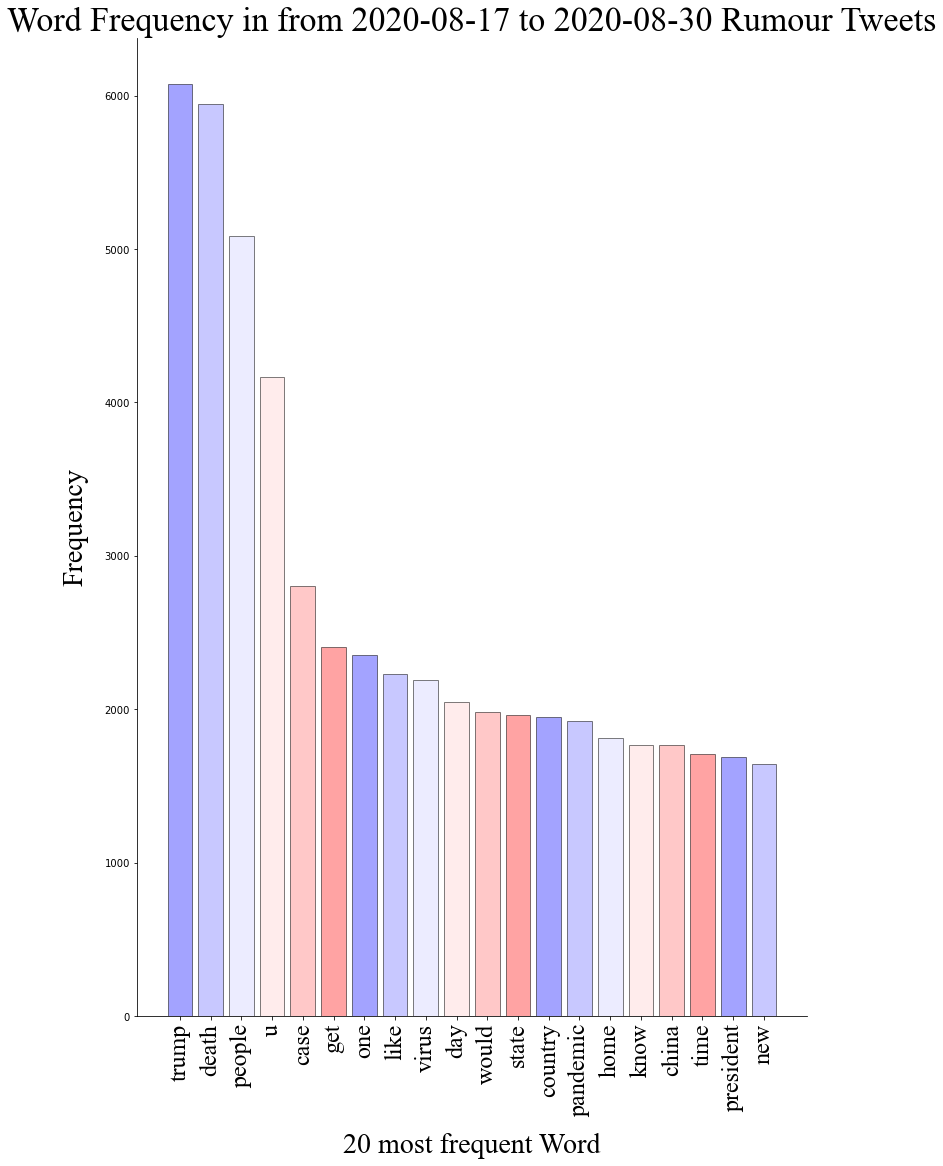

In [77]:
period_4_top_20_words = visualize_freq(period_4, 'text', 'Word', 20, 'from 2020-08-17 to 2020-08-30 Rumour', 'word-freq-rumour-period4.png')

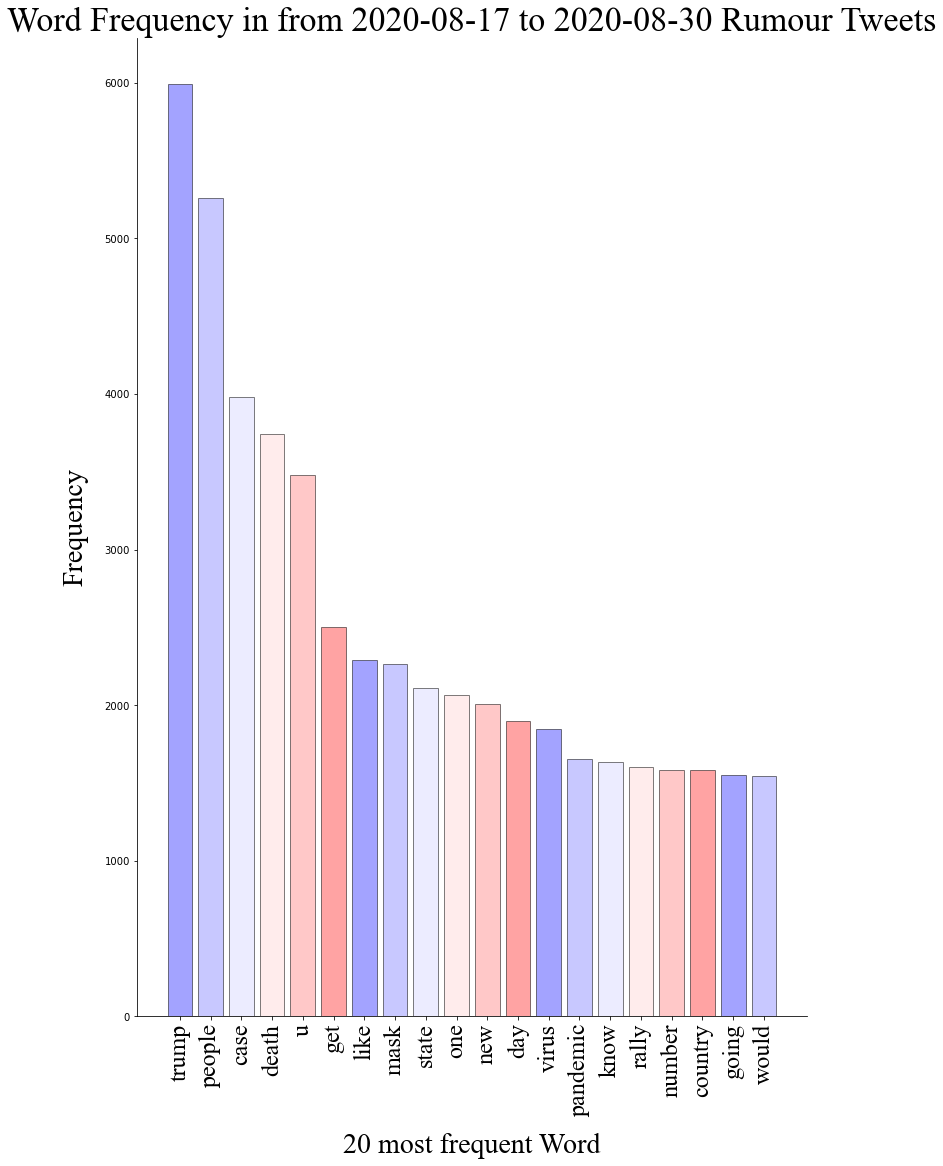

In [78]:
period_5_top_20_words = visualize_freq(period_5, 'text', 'Word', 20, 'from 2020-08-17 to 2020-08-30 Rumour', 'word-freq-rumour-period4.png')

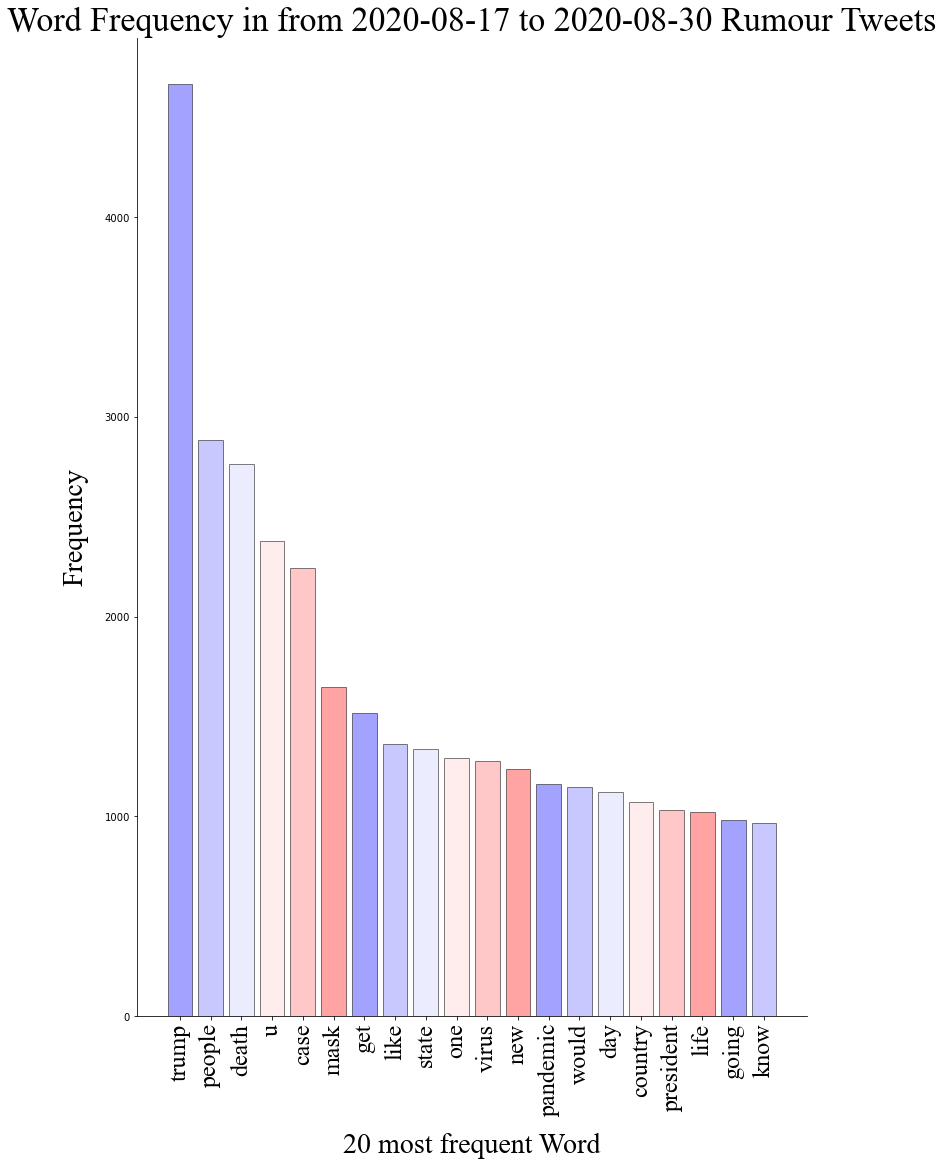

In [79]:
period_6_top_20_words = visualize_freq(period_6, 'text', 'Word', 20, 'from 2020-08-17 to 2020-08-30 Rumour', 'word-freq-rumour-period4.png')

In [80]:
frequent_words = list(period_1_top_20_words)
words = list(period_1_top_20_words) + list(period_2_top_20_words) + list(period_3_top_20_words) + list(period_4_top_20_words) + list(period_5_top_20_words) + list(period_6_top_20_words)
for word in words:
    if word not in frequent_words:
        frequent_words.append(word)

def period_word_cnt(set, word):
    corpus = []
    for i in range(len(set)):
        tweet = set['text'][i].split()
        if tweet != []:
            for val in tweet:
                corpus.append(val)
    counter = Counter(corpus)
    res = counter[word]
    return res

period1_freqs = {}
for word in frequent_words:
    freq = period_word_cnt(period_1, word)
    period1_freqs[word] = freq
frequent_words = sorted(period1_freqs, key=period1_freqs.get, reverse=True)

In [86]:
periods_freqs = []
for word in tqdm(frequent_words):
    instance = []
    for i in tqdm(range(6)):
        if i == 0:
            freq = period_word_cnt(period_1, word)
        if i == 1:
            freq = period_word_cnt(period_2, word)
        if i == 2:
            freq = period_word_cnt(period_3, word)
        if i == 3:
            freq = period_word_cnt(period_4, word)
        if i == 4:
            freq = period_word_cnt(period_5, word)
        if i == 5:
            freq = period_word_cnt(period_6, word)
        instance.append(freq)
    periods_freqs.append(instance)

periods_freqs = pd.DataFrame(periods_freqs)
periods_freqs.index = frequent_words
colums = ['Period1','Period2', 'Period3', 'Peroid4', 'Peroid5', 'Peroid6']
periods_freqs.columns = colums
periods_freqs

100%|██████████| 35/35 [1:33:22<00:00, 160.06s/it]


,Period1,Period2,Period3,Peroid4,Peroid5,Peroid6
trump,1092,3318,6743,6074,5991,4665
people,711,2968,5306,5088,5259,2886
u,596,2248,4501,4164,3477,2378
virus,486,2009,2310,2191,1847,1279
china,474,1331,2068,1766,832,431
get,465,1588,2653,2405,2502,1517
hoax,428,688,811,569,615,557
like,387,1243,2348,2232,2292,1365
know,302,989,1829,1767,1631,965
go,280,862,1463,1350,1455,894


In [108]:
drop_words = ['u', 'get', 'like', 'know', 'go', 'one', 'would', 'say', 'think', 'need', 'going', 'rally']

for drop_word in drop_words:
    periods_freqs = periods_freqs.drop(drop_word)

periods_freqs

,Period1,Period2,Period3,Peroid4,Peroid5,Peroid6
trump,1092,3318,6743,6074,5991,4665
people,711,2968,5306,5088,5259,2886
virus,486,2009,2310,2191,1847,1279
china,474,1331,2068,1766,832,431
hoax,428,688,811,569,615,557
spread,264,724,1098,919,1197,687
flu,253,620,885,639,420,307
president,238,955,2008,1689,1390,1030
country,226,1046,2083,1948,1580,1073
case,223,1114,2520,2803,3982,2244


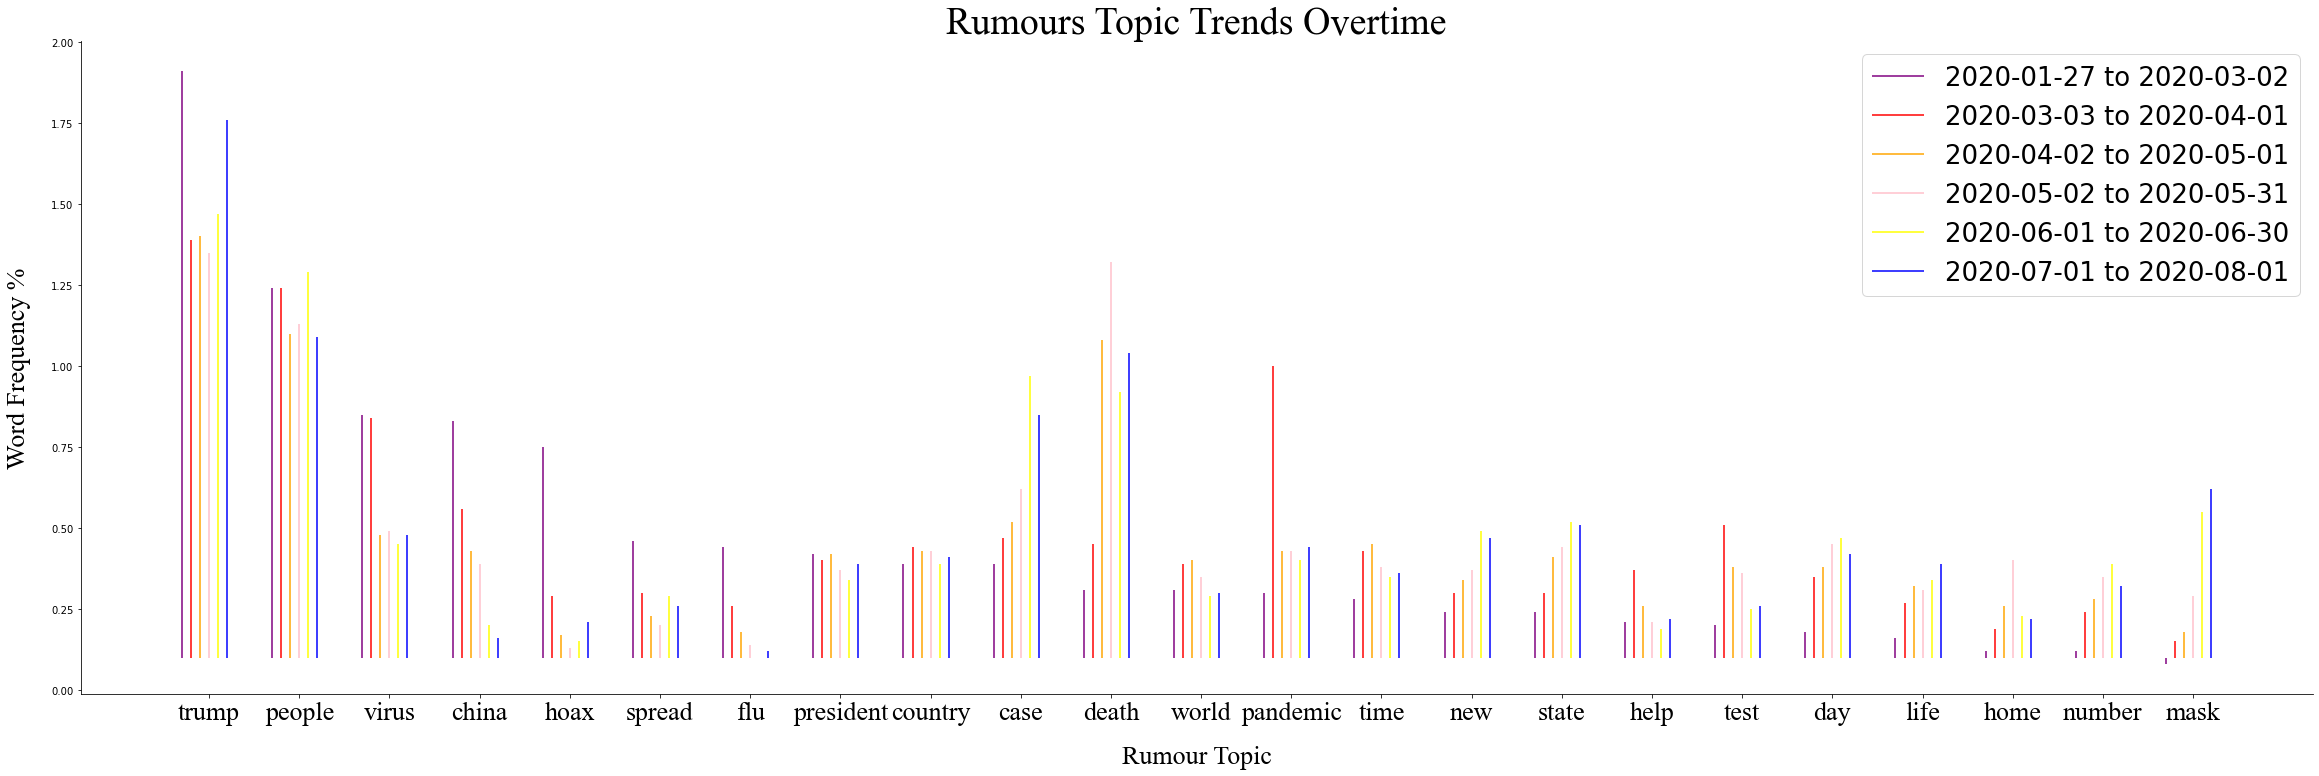

In [115]:
X = words
y_period1 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs.Period1.values)]
y_period2 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs.Period2.values)]
y_period3 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs.Period3.values)]
y_period4 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs['Peroid4'])]
y_period5 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs['Peroid5'])]
y_period6 = [round(freq/cnt_1, 4)*100 for freq in list(periods_freqs['Peroid6'])]


X_axis = np.arange(len(X))
plt.figure(figsize=(40, 12))
plt.vlines(X_axis - 0.3, y_period1, 0.1, label = '2020-01-27 to 2020-03-02', color = 'purple')
plt.vlines(X_axis - 0.2, y_period2, 0.1, label = '2020-03-03 to 2020-04-01', color = 'red')
plt.vlines(X_axis - 0.1, y_period3, 0.1, label = '2020-04-02 to 2020-05-01', color = 'orange')
plt.vlines(X_axis + 0, y_period4, 0.1, label = '2020-05-02 to 2020-05-31', color = 'pink')
plt.vlines(X_axis + 0.1, y_period5, 0.1, label = '2020-06-01 to 2020-06-30', color = 'yellow')
plt.vlines(X_axis + 0.2, y_period6, 0.1, label = '2020-07-01 to 2020-08-01', color = 'blue')

plt.xticks(X_axis, X, size=26, fontname="Times New Roman")
plt.xlabel("Rumour Topic", size=26, labelpad=20, fontname="Times New Roman")
plt.ylabel("Word Frequency %", size=26, labelpad=20, fontname="Times New Roman")
plt.title("Rumours Topic Trends Overtime", size=38, fontname="Times New Roman")
plt.legend(fontsize=26)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig('images/trend2.png', dpi=300, facecolor='w')
plt.show()

#### Sentiment Analysis

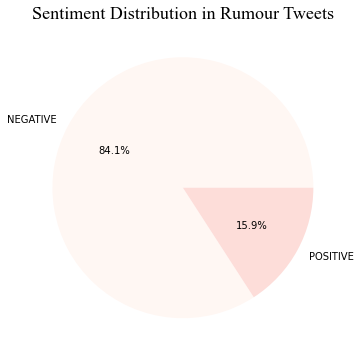

,frequency
NEGATIVE,21982
POSITIVE,4143


In [120]:
visualize_distribution(rumours, 'sentiment', 'Sentiment', 2, 'Rumour', 'rumour-sentiment-2.png')

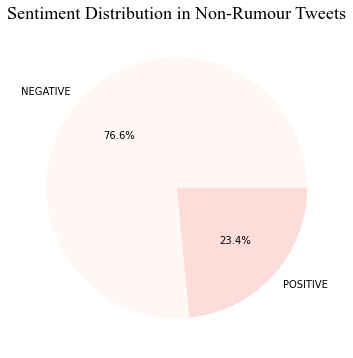

,frequency
NEGATIVE,104000
POSITIVE,31818


In [121]:
visualize_distribution(nonrumours, 'sentiment', 'Sentiment', 2, 'Non-Rumour', 'non-rumour-sentiment-2.png')